In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib, json, warnings
from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer


In [2]:
warnings.filterwarnings("ignore")

In [3]:
import os
print(os.getcwd())


f:\genai exchange hackathon\research


In [4]:
os.chdir("../")

In [5]:
%pwd

'f:\\genai exchange hackathon'

In [6]:
# Paths
DATA_DIR = Path("data")
DB0_FILE = DATA_DIR / "DB0_plant_config.csv"
DB1_FILE = DATA_DIR / "DB1_process_5min.csv"
DB2_FILE = DATA_DIR / "DB2_lab_hourly.csv"


In [7]:
AGG_WINDOW = "2H"
RESIDENCE_SHIFT_MIN = 37
MERGE_TOLERANCE = pd.Timedelta("3H")

In [8]:
# 2. Helper Functions

def safe_find_timestamp_col(df):
    candidates = [c for c in df.columns if any(k in c.lower() for k in ("time","date"))]
    return candidates[0]

def detect_targets(db2):
    targets = []
    for t in ["alite","belite","ferrite"]:
        matches = [c for c in db2.columns if t in c.lower()]
        targets.append(matches[0])
    return targets

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true==0, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

In [9]:
# Custom scorer
mape_scorer = make_scorer(lambda yt, yp: mape(yt, yp), greater_is_better=False)

In [11]:
# 3. Load Data
db0 = pd.read_csv(DB0_FILE)
db1 = pd.read_csv(DB1_FILE)
db2 = pd.read_csv(DB2_FILE)

In [12]:
print("Shapes:", db0.shape, db1.shape, db2.shape)

Shapes: (4, 11) (842112, 32) (70176, 21)


In [13]:
# 4. Preprocessing & Merge
# Timestamps
ts1_col = safe_find_timestamp_col(db1)
ts2_col = safe_find_timestamp_col(db2)

In [14]:
db1["timestamp"] = pd.to_datetime(db1[ts1_col])
db2["timestamp"] = pd.to_datetime(db2[ts2_col])

In [15]:
# Aggregate DB1
db1 = db1.set_index("timestamp").sort_index()
db1_num = db1.select_dtypes(include=[np.number])
db1_agg = db1_num.resample(AGG_WINDOW).mean().reset_index()
db1_agg["timestamp"] = db1_agg["timestamp"] + pd.Timedelta(minutes=RESIDENCE_SHIFT_MIN)

In [16]:
# Targets
targets = detect_targets(db2)
print("Detected targets:", targets)

Detected targets: ['clinker_XRD_alite_pct', 'clinker_belite_pct', 'clinker_ferrite_pct']


In [17]:
# Merge
merged = pd.merge_asof(
    db2.sort_values("timestamp"),
    db1_agg.sort_values("timestamp"),
    on="timestamp",
    direction="backward",
    tolerance=MERGE_TOLERANCE
)
merged = merged.dropna()

In [18]:
# Features/targets
y_cols = targets
X_cols = [c for c in merged.select_dtypes(include=[np.number]).columns if c not in y_cols]
X = merged[X_cols].astype(float)
y = merged[y_cols].astype(float)


In [19]:
print("Final dataset:", X.shape, y.shape)

Final dataset: (176, 44) (176, 3)


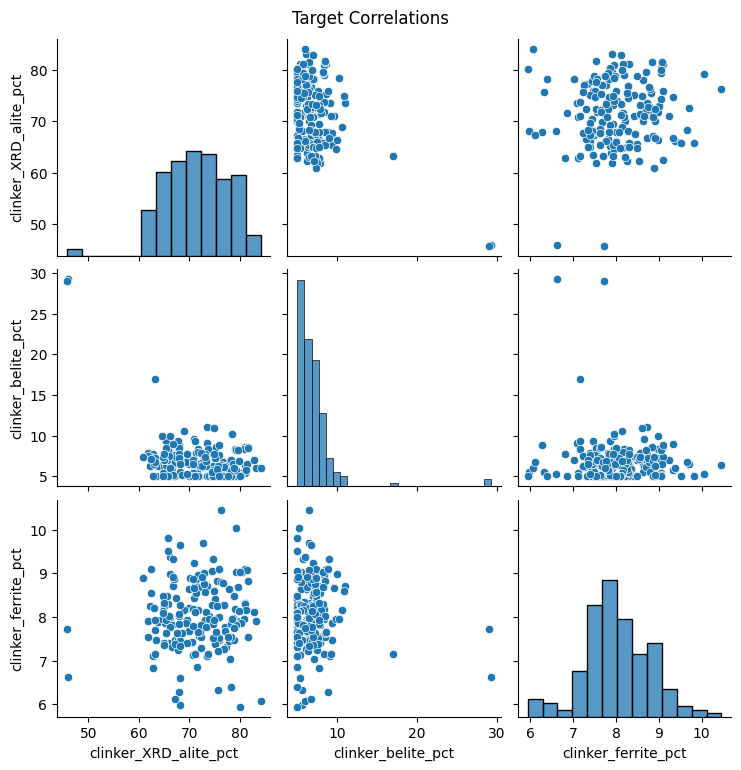

In [20]:
# 5. Data Exploration

sns.pairplot(merged[y_cols])
plt.suptitle("Target Correlations", y=1.02)
plt.show()

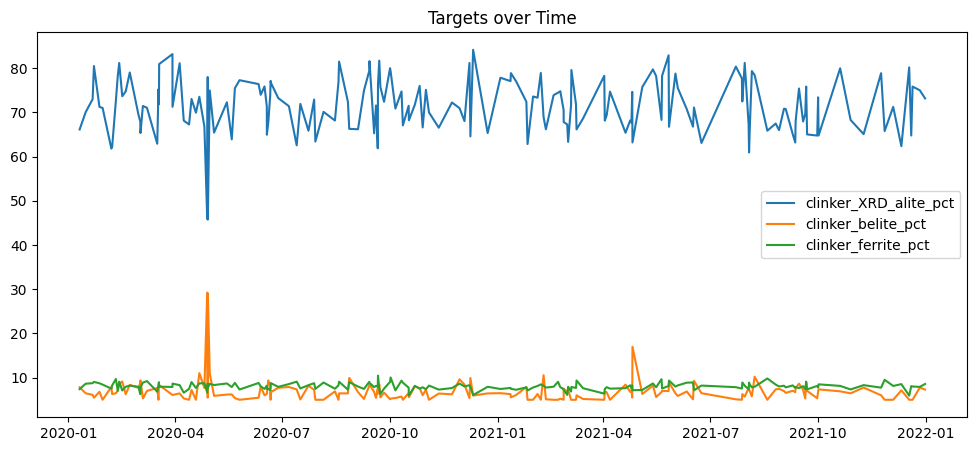

In [21]:
plt.figure(figsize=(12,5))
for col in y_cols:
    plt.plot(merged["timestamp"], merged[col], label=col)
plt.legend(); plt.title("Targets over Time"); plt.show()

In [22]:
# 6. Temporal Train/Test Split

merged = merged.sort_values("timestamp").reset_index(drop=True)
n = len(merged)
split = int(0.7*n)
train, test = merged.iloc[:split], merged.iloc[split:]
X_train, y_train = train[X_cols], train[y_cols]
X_test, y_test = test[X_cols], test[y_cols]

In [23]:
# 7. Baseline Models

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [24]:
gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200, random_state=42))
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

In [25]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
mlp = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(128,64), max_iter=300, random_state=42))
mlp.fit(X_train_s, y_train)
mlp_pred = mlp.predict(X_test_s)

In [26]:
def eval_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    mape_vals = [mape(y_true.iloc[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]
    print(f"\n{name} Results:")
    for i, col in enumerate(y_cols):
        print(f" {col}: MAE={mae[i]:.3f}, MAPE={mape_vals[i]:.2f}%")

In [27]:
eval_model("RandomForest", y_test, rf_pred)
eval_model("GradientBoosting", y_test, gbr_pred)
eval_model("NeuralNet", y_test, mlp_pred)


RandomForest Results:
 clinker_XRD_alite_pct: MAE=5.306, MAPE=7.54%
 clinker_belite_pct: MAE=1.035, MAPE=15.12%
 clinker_ferrite_pct: MAE=0.503, MAPE=6.19%

GradientBoosting Results:
 clinker_XRD_alite_pct: MAE=5.741, MAPE=8.19%
 clinker_belite_pct: MAE=1.403, MAPE=21.54%
 clinker_ferrite_pct: MAE=0.610, MAPE=7.51%

NeuralNet Results:
 clinker_XRD_alite_pct: MAE=10.741, MAPE=15.10%
 clinker_belite_pct: MAE=1.711, MAPE=25.33%
 clinker_ferrite_pct: MAE=1.248, MAPE=15.70%


In [28]:
# 8. Hyperparameter Search
param_dist_rf = {
    "n_estimators": [100,200,300,500],
    "max_depth": [10,20,30,None],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4],
}

In [29]:
search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10, scoring=mape_scorer,
    cv=3, n_jobs=-1, random_state=42, verbose=1
)

In [30]:
search_rf.fit(X_train, y_train)
print("Best RF Params:", search_rf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}


In [31]:
param_dist_gbr = {
    "estimator__n_estimators": [100,200,300],
    "estimator__learning_rate": [0.01,0.05,0.1],
    "estimator__max_depth": [3,5,7],
}

In [32]:
search_gbr = RandomizedSearchCV(
    MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    param_distributions=param_dist_gbr,
    n_iter=10, scoring=mape_scorer,
    cv=3, n_jobs=-1, random_state=42, verbose=1
)

In [33]:
search_gbr.fit(X_train, y_train)
print("Best GBR Params:", search_gbr.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best GBR Params: {'estimator__n_estimators': 100, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.05}


In [34]:
# 9. Tuned Model Evaluation

rf_tuned = search_rf.best_estimator_
gbr_tuned = search_gbr.best_estimator_

In [35]:
rf_tuned_pred = rf_tuned.predict(X_test)
gbr_tuned_pred = gbr_tuned.predict(X_test)

eval_model("RF Tuned", y_test, rf_tuned_pred)
eval_model("GBR Tuned", y_test, gbr_tuned_pred)


RF Tuned Results:
 clinker_XRD_alite_pct: MAE=5.284, MAPE=7.49%
 clinker_belite_pct: MAE=1.037, MAPE=15.31%
 clinker_ferrite_pct: MAE=0.502, MAPE=6.19%

GBR Tuned Results:
 clinker_XRD_alite_pct: MAE=5.462, MAPE=7.77%
 clinker_belite_pct: MAE=1.318, MAPE=20.00%
 clinker_ferrite_pct: MAE=0.573, MAPE=7.06%


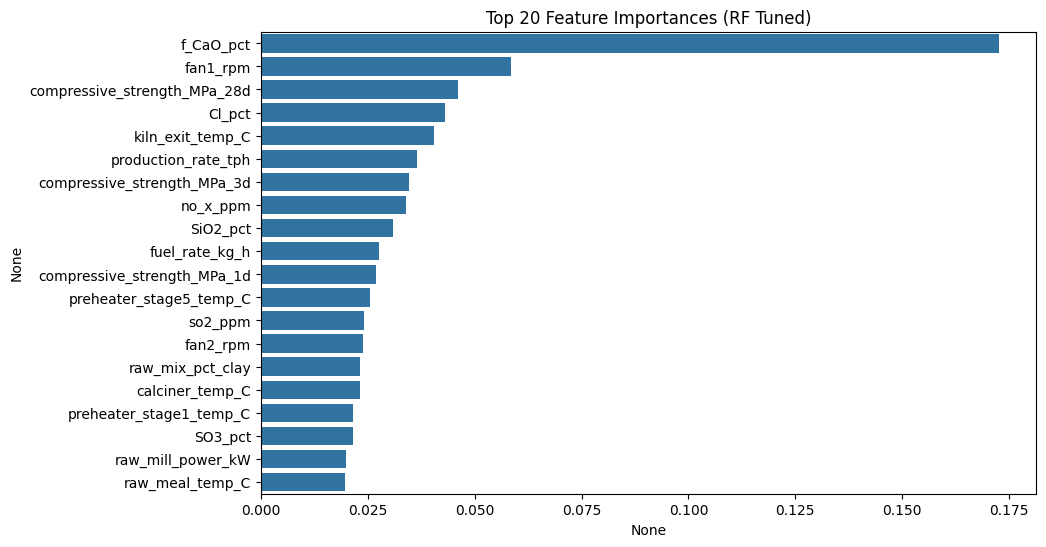

In [38]:
# 10. Feature Importances

importances = pd.Series(rf_tuned.feature_importances_, index=X_cols).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:20], y=importances.index[:20])
plt.title("Top 20 Feature Importances (RF Tuned)")
plt.show()